# Overview

This notebook contains all code and discussions for the __intermediate iteration__ of the research question involving __lesion coloration and malignancy__. The specific question is whether, to a statistically significant degree, coloration (*i.e.*, darkness or intensity) can be used to predict malignancy (*i.e.*, occurrence of malignant diagnosis). At this level, the question involves ANOVA and logistic regression techniques. It is an advancement of [the novice module](../novice/Q1.ipynb) on this topic.

# Table of Content

I. [Setup](#s)

II. [Data Retrieval](#dr)

1. [File Access](#fa)
2. [Loading & Processing](#lp)

III. [Analysis](#anl)

1. [ANOVA](#anova)
2. [Logistic Regression](#lr)


IV. [Discussion](#discuss)

# Setup <a id='s'></a>

Refer to [this module](../novice/Data_Download.ipynb) for replicating the data-download process using the ISIC Python tool. The command is repeated below, although file/directory locations may need adjustment. 

`
python download_archive.py \
--num-images=50 \ 
--images-dir ../../sample_imgs \ 
--descs-dir ../../sample_dscs -s \ 
--seg-dir ../../sample_segs --seg-skill expert
`

The following are necessary imports for this module.

In [1]:
# file access
import json
import glob 

# image handling
from PIL import Image

# data manipulation and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# analysis
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

# Data Retrieval <a id='dr'></a>

## File Access <a id='fa'></a>

As seen in novice modules, all three pieces of data are needed in this question: images, segmentations, and descriptions. Load as before.

In [2]:
img_filepaths = glob.glob('../../sample_imgs/*.jp*')
seg_filepaths = glob.glob('../../sample_segs/*.png')
dsc_filepaths = glob.glob('../../sample_dscs/*')

print(len(img_filepaths), 'images')
print(len(seg_filepaths), 'segmentation files')
print(len(dsc_filepaths), 'descriptions')

50 images
50 segmentation files
50 descriptions


Loop through the image filepaths to make sure the identifying numbers in every $k^{th}$ image file matches the number in the corresponding $k^{th}$ segmentation and description files. That is, check that the corresponding elements of the three lists refer to the same data point.

In [3]:
for i in range(len(img_filepaths)):
    img_num = int(img_filepaths[i].split('_')[-1].split('.')[0])
    seg_num = int(seg_filepaths[i].split('_')[-2])
    dsc_num = int(dsc_filepaths[i].split('_')[-1])   
    wrong_dsc = (dsc_num != img_num) or (dsc_num != seg_num)
    wrong_seg = seg_num != img_num  
    if wrong_dsc or wrong_seg:
        print("Error in file order")
        break
print('File order validated.')

Validated.


## Loading & Processing <a id='lp'></a>

There's only one required part of the description files, which is the benign/malignant indicator. Descriptions (JSON format) have this information nested in the `clinical`-`meta`-`benign_malignant` key.

In [4]:
json.load(open(dsc_filepaths[0], 'r'))

{'_id': '5436e3abbae478396759f0cf',
 '_modelType': 'image',
 'created': '2014-10-09T19:36:11.989000+00:00',
 'creator': {'_id': '5450e996bae47865794e4d0d', 'name': 'User 6VSN'},
 'dataset': {'_accessLevel': 0,
  '_id': '5a2ecc5e1165975c945942a2',
  'description': 'Moles and melanomas.\nBiopsy-confirmed melanocytic lesions. Both malignant and benign lesions are included.',
  'license': 'CC-0',
  'name': 'UDA-1',
  'updated': '2014-11-10T02:39:56.492000+00:00'},
 'meta': {'acquisition': {'image_type': 'dermoscopic',
   'pixelsX': 1022,
   'pixelsY': 767},
  'clinical': {'age_approx': 55,
   'anatom_site_general': 'anterior torso',
   'benign_malignant': 'benign',
   'diagnosis': 'nevus',
   'diagnosis_confirm_type': None,
   'melanocytic': True,
   'sex': 'female'}},
 'name': 'ISIC_0000000',
 'notes': {'reviewed': {'accepted': True,
   'time': '2014-11-10T02:39:56.492000+00:00',
   'userId': '5436c6e7bae4780a676c8f93'},
  'tags': ['Challenge 2018: Task 1-2: Training',
   'Challenge 2019:

Create a new list where each $k^{th}$ description is represented by the $k^{th}$ malignancy value.

In [5]:
dscs = [json.load(open(x, 'r'))['meta']['clinical'] for x in dsc_filepaths]
flags = [x['benign_malignant'] for x in dscs]

# sample output
for i in range(3):
    print('Data point #%d: %s' % (i, flags[i]))

Data point #0: benign
Data point #1: benign
Data point #2: malignant


The image files need to be opened and made into matrices. The matrices have the following structure:

- *m* rows
    - *n* columns per row
        - *3* pixel values (RGB order or red, green, blue pixel values) per column 
        
All images can be opened according to this pattern.

In [6]:
images = [Image.open(x).resize((400,300)) for x in img_filepaths]
images = [np.array(x.convert('RGB')) for x in images]

Segmentation files, as seen in previous modules, can be opened without RGB notation. Their structure is:
 
- *m* rows
    - *n* columns
        - *1* value (0 for benign, 1 for malignant) per column (not an array of 3 like in the images)

In [7]:
segs = [Image.open(x).resize((400,300)) for x in seg_filepaths]
segs = [np.array(x) for x in segs]

The next step is to use the segmentations to extract only the lesion part of the images. Notice how the segmentation creates a boundary; coordinates in the dark area are not relevant.

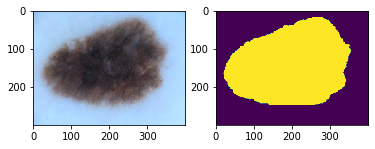

In [8]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(images[0])
axs[1].imshow(segs[0])
plt.show()

The above images give an idea of how to extract the meaningful portion. Although the segmentation appears colored, it is actually black and white. At any location *m,n*, a 0 indicates a black (non-relevant pixel), and non-0 value indicates lesion area. Test by locating points that are visibly inside the lesion area.

In [9]:
# naked-eye test for location in the lesion area at row 100, column 300
x1, s1 = images[0][100,300], segs[0][100,300]
print('At row 100, column 300 the segmentation value is non-black/non-0:', s1)

# naked-eye test for location outside at row 10, column 50
x1, s1 = images[0][10,50], segs[0][10,50]
print('At row 10, column 50 the segmentation value is black/0:', s1)

At row 100, column 300 the segmentation value is non-black/non-0: 255
At row 10, column 50 the segmentation value is black/0: 0


If a black pixel occurs within the lesion, it is part of the lesion's coloring, and should be counted (to distinguish between very dark and very very dark cells, for example). With this in mind, use indexing to extract the lesion-only portion for a sample image.

In [10]:
test_img = images[0]
test_seg = segs[0]

Find all non-0 (non-black) occurrences in the segmentation. WHAT DOES THE RESULT MEAN (FIXME?)

In [11]:
idxs = np.where(test_seg)
idxs

(array([ 17,  17,  17, ..., 248, 248, 248]),
 array([250, 251, 252, ..., 254, 255, 256]))

Use these locations to extract only the lesion portions of the image.

In [12]:
test_rdx = test_img[idxs]
for i in range(3):
    rgb = test_rdx[i]
    print('RGB at location #%d where segmentation is non-0: %s' % (i, rgb))

RGB at location #0 where segmentation is non-0: [155 186 216]
RGB at location #1 where segmentation is non-0: [156 187 217]
RGB at location #2 where segmentation is non-0: [157 187 216]


Apply this filtering to all images. Each element of the resulting list represents one image, and consists of a non-constant amount of triplets representing the relevant RGB pixels for that image. 

In [13]:
image_rdxs = []
for i in range(len(segs)):
    idxs = np.where(segs[i]) # clarify that default is checking 0 value
    image_rdx = images[i][idxs] # test code that shows how np.where successfully tells you the right locations
    image_rdxs.append(image_rdx)

# Analysis <a id='anl'></a>

## ANOVA <a id='anova'></a>

If the above list represents image "subsets", ANOVA can be used to identify significant differences in color among these subsets, given some grouping thereof. First, the subsets have to be boiled down from lists of RGB values to one value. See the first data point:

In [14]:
image_rdxs[0]

array([[155, 186, 216],
       [156, 187, 217],
       [157, 187, 216],
       ...,
       [164, 181, 214],
       [164, 181, 215],
       [163, 180, 215]], dtype=uint8)

In each RGB triplet, the first value is the red pixel value, the second the green value, and lastly the blue value. Access the mean red, green, and blue values across all these triplets. 

In [15]:
R, G, B = np.mean(image_rdxs[0], axis=0)
print('Mean R: %0.1f, mean G: %0.1f, mean B: %0.1f' % (R,G,B))

Mean R: 88.1, mean G: 80.7, mean B: 86.5


This can be turned into a single, hexadecimal number (how colors are commonly represented), yielding one numeric summary of the averaged RGB-combination in this image.

In [16]:
hex_value = '%02x%02x%02x' % (int(R), int(G), int(B))
print('The hex representation is', hex_value)

The hex representation is 585056


Apply to all images.

In [17]:
rgb_means = [np.mean(x, axis=0) for x in image_rdxs]
rgb_means = [(int(r), int(g), int(b)) for (r,g,b) in rgb_means]
hex_values = ['%02x%02x%02x' % (r,g,b) for (r,g,b) in rgb_means]

# sample output
for i in range(3):
    print('Image #%d as hex: %s' % (i, hex_values[i]))

Image #0 as hex: 585056
Image #1 as hex: 52392d
Image #2 as hex: 826d71


Now apply a grouping to these colors. Turn the hex values into their integer counterparts, and sort the images from light to dark (*e.g.*, lowest int values to darkest).

In [18]:
hex_to_int = [int(x,16) for x in hex_values]
sorted_ints = sorted(hex_to_int)

An example grouping is given: the lightest four images are the 'light' group, the next four are the 'medium' group, the remaining darkest colors are the 'dark' group.

In [19]:
light, med, dark = sorted_ints[:4], sorted_ints[4:8], sorted_ints[8:]

Performing one-way ANOVA (no response) gives a test statistic and p-value. If p < 0.05 (the common standard), reject the null hypothesis (no significant difference among groups) and argue in favor of the alternative hypothesis.

__*Note:*__ the alternative hypothesis in this case argues that there is significant difference in __color__ among these images. It says that there are non-trivial differences in color among the groups, and so the data is not an essentially identical set of images.

In [20]:
f_oneway(light, med, dark)

F_onewayResult(statistic=26.455563979269257, pvalue=2.0108232776775616e-08)

## Logistic Regression <a id='lr'></a>

To predict malignancy based on color, notice the binary response (benign/malignant) and multiple predictors (mean R, mean G, mean B). Logistic Regression is perfect for such a binary classification problem. The hexadecimal operations aren't even needed, since each color channel can be entered as a separate attribute. 

Begin with the response variables. They are still in the order in which they were loaded from files, and can be encoded into binary numeric outcomes. Benign is 0, malignant is 1. 

In [21]:
le = LabelEncoder()
y = le.fit_transform(flags)
y.shape

(50,)

Mean R,G,B values have already been obtained for each image. Refer to the step prior to sorting color values.

In [22]:
for i in range(3):
    print('RGB for Image %d is %s' % (i, rgb_means[i]))

RGB for Image 0 is (88, 80, 86)
RGB for Image 1 is (82, 57, 45)
RGB for Image 2 is (130, 109, 113)


Transform into a numeric array, and then create splits of the data for training, validating, and testing the model.

In [23]:
X = np.array(rgb_means)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# verify results
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(40, 3) (10, 3)
(40,) (10,)


Set up Logistic Regression using the F1 metric for the binary classification problem (this is a weighted mean of precision and recall, and relevant to this task). Create a 'grid' of hyper-parameters for the internal Logistic Regression training process, so that the best combinations thereof can be found. Finally, train on training data and show progress.

In [50]:
# l1 refers to lasso regression, l2 to ridge regression
hyperparameters = {'C': np.logspace(-3,2,6), 'penalty':['l1', 'l2']} 

# default 5-fold CV is used
clf = GridSearchCV(LogisticRegression(solver='liblinear'), hyperparameters, scoring='f1') # is scoring by f1 wrong?
clf.fit(X_train, y_train)
print('Optimized parameters', clf.best_params_)

lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.001, max_iter=200)
lr.fit(X_train, y_train)

Optimized parameters {'C': 10.0, 'penalty': 'l1'}


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Output F1-based performance from the model, on test data to determine generalizability. This value should be close to 1 (the maximum) and far from 0. 

In [51]:
preds_test = lr.predict(X_test)
f1 = f1_score(y_test, preds_test) # try again
print('F1:', f1)

F1: 0.0


In [52]:
print(y_test)
print(preds_test)
print(np.mean(y_test == preds_test))
# calc prec/recall yourself and see if different

[0 0 0 0 1 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0]
0.7


For a more visual result, consider the ROC plot, which should maximize the Area Under Curve (AUC).

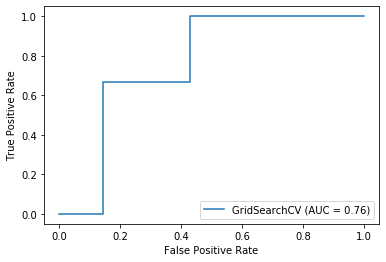

In [53]:
plot_roc_curve(clf, X_test, y_test)

# Discussion <a id='discuss'></a>

*__ANOVA__*

*Discuss the findings revealed by ANOVA on the manual groupings of images by coloration.*

*__Logistic Regression__*

*Discuss the impact and accuracy of Logistic Regression on malignancy using colors as predictors.*